In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

C:\Users\himanshu\anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
df=pd.read_csv("Corona_NLP_train.csv",encoding='ISO-8859-1')

In [3]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [4]:
df.Sentiment.replace(to_replace='Extremely Positive', value='Positive',inplace=True)
df.Sentiment.replace(to_replace='Extremely Negative', value='Negative',inplace=True)
print(df.Sentiment.value_counts())
df = df[['OriginalTweet','Sentiment']]
df.head(10)

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive
7,Was at the supermarket today. Didn't buy toile...,Neutral
8,Due to COVID-19 our retail store and classroom...,Positive
9,"For corona prevention,we should stop to buy th...",Negative


In [5]:
df.shape

(41157, 2)

In [6]:
import re
import string
stop_words = stopwords.words("english")
def clean_text(text):
    text = text.lower()
    # remove mentions
    text = re.sub("@\S+", " ", text)
    # remove url
    text = re.sub("https*\S+", " ", text)
    # remove hashtags
    text = re.sub("#\S+", " ", text)
    # remove all numbers
    text = re.sub("\d", " ", text)
    # remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # remove extra spaces
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    # stopwords     
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    # remove non-Latin characters
    text = re.sub('[^a-zA-Z\s]', '', text)
    return text

In [7]:
df.OriginalTweet=df.OriginalTweet.apply(clean_text)


C:\Users\himanshu\AppData\Local\Temp\ipykernel_19664\916101714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.OriginalTweet=df.OriginalTweet.apply(clean_text)


In [8]:
df

,OriginalTweet,Sentiment
0,,Neutral
1,advice talk neighbours family exchange phone n...,Positive
2,coronavirus australia woolworths give elderly ...,Positive
3,food stock one empty please panic enough food ...,Positive
4,ready go supermarket outbreak paranoid food st...,Negative
...,...,...
41152,airline pilots offering stock supermarket shel...,Neutral
41153,response complaint provided citing covid relat...,Negative
41154,know its getting tough rationing toilet paper ...,Positive
41155,wrong smell hand sanitizer starting turn,Neutral


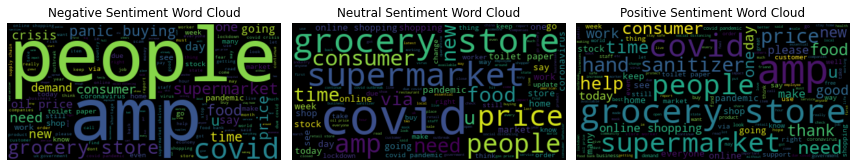

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_text = ' '.join(df[df.Sentiment == 'Negative'].OriginalTweet.tolist())
neutral_text = ' '.join(df[df.Sentiment == 'Neutral'].OriginalTweet.tolist())
positive_text = ' '.join(df[df.Sentiment == 'Positive'].OriginalTweet.tolist())

# Create WordCloud objects for each sentiment
negative_wordcloud = WordCloud().generate(negative_text)
neutral_wordcloud = WordCloud().generate(neutral_text)
positive_wordcloud = WordCloud().generate(positive_text)

# Create subplots for negative, neutral, and positive word clouds
plt.figure(figsize=(12, 8))

# Negative Word Cloud
plt.subplot(131)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')

# Neutral Word Cloud
plt.subplot(132)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment Word Cloud')
plt.axis('off')

# Positive Word Cloud
plt.subplot(133)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

# Show the subplots
plt.tight_layout()
plt.show()

In [10]:
import spacy
# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_lg')

In [11]:
# process a sentence using the model
doc = nlp("This is some text that I am processing with Spacy")
# It's that simple - all of the vectors and words are assigned after this point

In [12]:
# Get the vector for 'text':
doc[-3], doc[-3].vector


(processing,
 array([-0.98158 , -2.6326  , -0.02352 ,  3.2856  ,  3.63    , -1.2795  ,
         3.6477  ,  4.1457  , -3.911   , -1.8988  ,  6.3144  ,  3.7014  ,
        -5.9561  ,  5.1211  , -1.8175  , -1.0002  ,  7.4333  ,  1.6981  ,
        -4.4509  , -1.9858  , -2.1477  ,  3.4198  , -5.8983  ,  1.8785  ,
        -3.4049  , -2.1389  , -0.63041 , -1.8979  ,  0.10881 , -0.63591 ,
         3.8009  ,  0.89979 , -4.6852  ,  0.17034 , -0.29025 , -5.6625  ,
         4.1363  ,  1.0943  ,  3.3971  ,  1.8353  ,  0.15847 , -0.96643 ,
         2.9794  , -0.68237 , -4.4391  ,  2.494   ,  4.9149  , -0.63641 ,
        -2.7878  , -2.0478  , -0.20991 ,  3.1249  , -1.678   , -5.3789  ,
        -2.6653  ,  0.82363 , -2.2348  ,  1.5312  ,  1.861   , -2.0801  ,
         4.343   ,  1.5988  , -2.3153  ,  0.62286 ,  3.0526  ,  1.7596  ,
        -3.0563  , -4.1593  , -1.0461  ,  0.62876 , -2.6396  ,  0.23815 ,
        -3.8904  ,  2.0345  , -1.1544  , -0.37425 , -5.1358  ,  3.371   ,
         0.90354 , -0.215

In [13]:
# Get the mean vector for the entire sentence (useful for sentence classification etc.)
doc.vector

array([ 0.13538204, -0.50049055,  0.26314098, -1.8586416 , -0.57580197,
       -0.07358702, -0.035399  ,  4.4508467 , -3.7474205 ,  1.6460339 ,
        6.90367   ,  1.3508627 , -2.7805922 , -0.6575441 ,  2.2817955 ,
        0.993958  ,  2.383111  , -0.21607213, -1.462939  ,  0.92183   ,
        1.0806081 ,  1.930987  , -3.292195  , -1.8399448 , -2.533392  ,
       -1.9827248 , -1.564382  , -1.138241  , -2.0831861 , -0.430525  ,
       -0.403931  , -0.11929995, -3.6540642 ,  0.19895704, -1.9910061 ,
        0.3238971 , -0.34544173,  0.969619  ,  5.6958246 ,  2.223509  ,
       -1.6114123 ,  2.346086  , -0.700554  , -1.539235  , -1.0771002 ,
        2.6830828 ,  3.4063332 , -2.901462  , -2.5829167 ,  1.1031249 ,
        1.362951  , -0.530291  ,  2.270077  , -4.8443303 , -1.537749  ,
        0.49870294,  2.492154  ,  1.8763611 ,  0.89088696,  0.88795805,
        4.37719   ,  0.06023499, -1.3463123 ,  0.22848296, -1.0967581 ,
        1.9763839 , -2.2734218 , -4.24074   ,  2.6045609 ,  3.91

In [14]:
def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

In [15]:
embeddings=[]
for x in df.OriginalTweet:
    #print(x)
    #embeddings.append([nlp(word).vector for word in x])
    embeddings.append(nlp(x).vector)


In [16]:
embeddings[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [17]:
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [18]:
df.Sentiment

0         Neutral
1        Positive
2        Positive
3        Positive
4        Negative
           ...   
41152     Neutral
41153    Negative
41154    Positive
41155     Neutral
41156    Negative
Name: Sentiment, Length: 41157, dtype: object

C:\Users\himanshu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

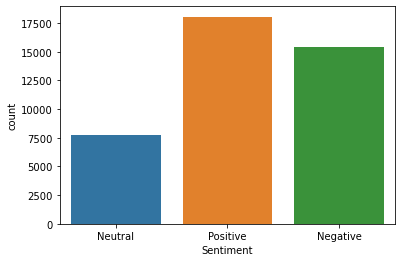

In [19]:
sns.countplot(df.Sentiment)

In [20]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()


In [21]:
df['Sentiment']=le.fit_transform(df['Sentiment'])

C:\Users\himanshu\AppData\Local\Temp\ipykernel_19664\3747046912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment']=le.fit_transform(df['Sentiment'])


In [22]:
from imblearn.over_sampling import SMOTE

# SMOTE

In [23]:
# Apply SMOTE to the TF-IDF feature space
smote = SMOTE(random_state=42)
X_sm,y_sm = smote.fit_resample(embeddings,df.Sentiment)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.2)

In [25]:
y_train

4947     2
1483     2
117      2
5532     0
29398    0
        ..
52506    1
36510    1
44927    1
5000     2
48265    1
Name: Sentiment, Length: 43310, dtype: int32

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def eval_model(y_true,y_predicted):
    cm = confusion_matrix(y_true, y_predicted) 
    cm_display=ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    print('accuracy score',accuracy_score(y_true, y_predicted))
    print(classification_report(y_true,y_predicted))


C:\Users\himanshu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score 0.6999445881049132
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      3546
           1       0.69      0.72      0.70      3668
           2       0.72      0.68      0.70      3614

    accuracy                           0.70     10828
   macro avg       0.70      0.70      0.70     10828
weighted avg       0.70      0.70      0.70     10828



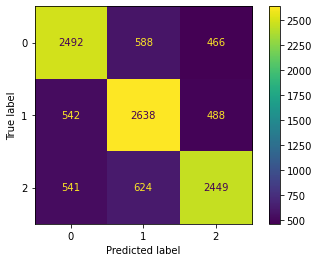

In [27]:
from sklearn.linear_model import LogisticRegression  

model = LogisticRegression(max_iter=100) 
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


eval_model(y_test, y_pred)


accuracy score 0.7216475803472479
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      3546
           1       0.78      0.81      0.79      3668
           2       0.68      0.66      0.67      3614

    accuracy                           0.72     10828
   macro avg       0.72      0.72      0.72     10828
weighted avg       0.72      0.72      0.72     10828



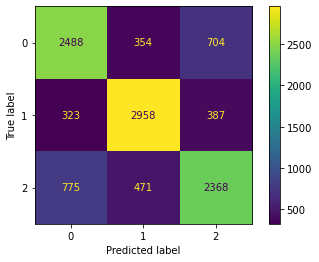

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

eval_model(y_test, rf_y_pred)


In [29]:
import xgboost as xgb

In [30]:
xgb_i=xgb.XGBClassifier()


accuracy score 0.7392870336165497
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      3546
           1       0.77      0.79      0.78      3668
           2       0.72      0.70      0.71      3614

    accuracy                           0.74     10828
   macro avg       0.74      0.74      0.74     10828
weighted avg       0.74      0.74      0.74     10828



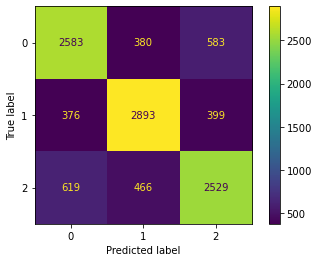

In [31]:
xgb_i.fit(X_train, y_train)

xgb_y_pred = xgb_i.predict(X_test)

eval_model(y_test, xgb_y_pred)

In [32]:
from sklearn.tree import DecisionTreeClassifier

accuracy score 0.5520871813816033
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      3546
           1       0.61      0.63      0.62      3668
           2       0.52      0.50      0.51      3614

    accuracy                           0.55     10828
   macro avg       0.55      0.55      0.55     10828
weighted avg       0.55      0.55      0.55     10828



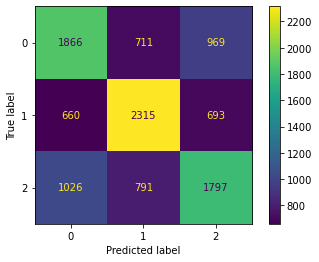

In [33]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)

dtc_y_pred = dtc_model.predict(X_test)

eval_model(y_test, dtc_y_pred)


In [34]:
from sklearn.ensemble import ExtraTreesClassifier


In [35]:
clf_model = ExtraTreesClassifier(n_estimators=100, random_state=42)


accuracy score 0.7485223494643517
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      3546
           1       0.84      0.83      0.84      3668
           2       0.70      0.68      0.69      3614

    accuracy                           0.75     10828
   macro avg       0.75      0.75      0.75     10828
weighted avg       0.75      0.75      0.75     10828



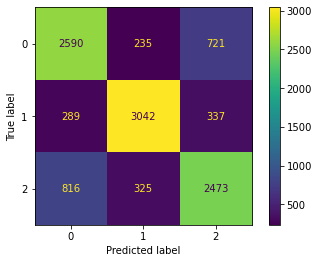

In [36]:
clf_model.fit(X_train, y_train)

clf_y_pred = clf_model.predict(X_test)

eval_model(y_test, clf_y_pred)


In [37]:
knc_model=KNeighborsClassifier()

accuracy score 0.6244920576283709
              precision    recall  f1-score   support

           0       0.62      0.70      0.66      3546
           1       0.60      0.89      0.71      3668
           2       0.77      0.28      0.42      3614

    accuracy                           0.62     10828
   macro avg       0.66      0.62      0.59     10828
weighted avg       0.66      0.62      0.59     10828



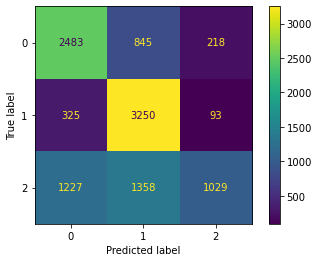

In [38]:
knc_model.fit(X_train, y_train)

knc_y_pred = knc_model.predict(X_test)

eval_model(y_test, knc_y_pred)
